In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:22<00:00,  5.71it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


In [4]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

# Prompt and Answer Mapping

In [5]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = ""
    for conv in convos:
        if conv["role"] == "user":
            user_prompts = user_prompts + " " + conv["text"]
    if(user_prompts == ""):
      continue
    prompts.append(user_prompts)
    code2prompts[code] = user_prompts

In [6]:
answers = []
code2answers= defaultdict(list)
for code , convos in code2convos.items():
    gpt_ans = ""
    for conv in convos:
        if conv["role"] == "assistant":
            gpt_ans = gpt_ans + " " + conv["text"]
    if(gpt_ans == ""):
      continue
    answers.append([gpt_ans])
    code2answers[code] = gpt_ans

In [7]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]
scores.dropna(inplace = True)
# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


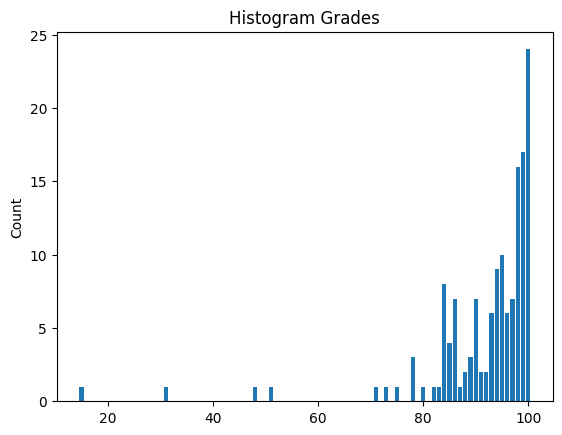

In [8]:
plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [199]:
bins = [0, 60, 80, 87, 93, 97,100]
scores['grade_bin'] = pd.cut(scores['grade'], bins=bins, labels=False)

In [200]:
counts = scores.grade.value_counts()
sorted_counts = counts.sort_index()
sorted_counts

15.0      1
31.0      1
48.0      1
51.0      1
71.0      1
73.0      1
75.0      1
78.0      3
80.0      1
82.0      1
83.0      1
84.0      8
85.0      4
86.0      7
87.0      1
88.0      2
89.0      3
90.0      7
91.0      2
92.0      2
93.0      6
94.0      9
95.0     10
96.0      6
97.0      7
98.0     16
99.0     17
100.0    24
Name: grade, dtype: int64

In [201]:
code_prompts = pd.DataFrame(code2prompts, index=[0]).T
code_prompts.reset_index(inplace=True)
code_prompts.rename(columns={0: "prompts"}, inplace=True)
code_prompts.rename(columns={"index" : "code"}, inplace=True)

In [202]:
code_ans = pd.DataFrame(code2answers, index=[0]).T
code_ans.reset_index(inplace=True)
code_ans.rename(columns={0: "answers"}, inplace=True)
code_ans.rename(columns={"index" : "code"}, inplace=True)

In [203]:
df_prompt = pd.merge(code_prompts, scores, on="code", how="left")
df_prompt.head()

,code,prompts,grade,grade_bin
0,0031c86e-81f4-4eef-9e0e-28037abf9883,Load a CSV file into a Pandas in Python. The ...,48.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,I have a dataset that contains the following ...,99.0,5.0
2,041f950b-c013-409a-a642-cffff60b9d4b,I have a csv file data with Columns:\n\nspeci...,90.0,3.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,How can I display variable names in a pandas ...,97.0,4.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,I am doing a machine leraning homework using ...,100.0,5.0


In [204]:
# Convert to lower case
df_prompt['prompts'] = df_prompt['prompts'].str.lower()

In [205]:
df_prompt.dropna(inplace=True)
df_prompt.drop_duplicates("code",inplace=True, keep="first")
df_prompt = df_prompt.reset_index(drop=True)

In [206]:
df_ans = pd.merge(code_ans, scores, on="code", how="left")
df_ans.head()

,code,answers,grade,grade_bin
0,0031c86e-81f4-4eef-9e0e-28037abf9883,You can load a CSV file into a Pandas DataFra...,48.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,Great! It looks like you have a comprehensive...,99.0,5.0
2,041f950b-c013-409a-a642-cffff60b9d4b,Certainly! Let's go through each step.Step 1:...,90.0,3.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,"In Pandas, you can display variable (column) ...",97.0,4.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,Absolutely! Here's the code to import the nec...,100.0,5.0


In [207]:
# Convert to lower case
df_ans['answers'] = df_ans['answers'].str.lower()

In [208]:
df_ans.dropna(inplace=True)
df_ans.drop_duplicates("code",inplace=True, keep="first")
df_ans = df_ans.reset_index(drop=True, )

# Oversampling

In [209]:
from sklearn.utils import shuffle
df_prompt = df_ans
df_prompt = shuffle(df_prompt)

In [211]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming df_prompt['prompts'] is your text data
vectorizer = TfidfVectorizer()

# Fit the vectorizer and transform the text data
X = vectorizer.fit_transform(df_prompt['answers'])
X = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names_out())

X['grade'] = df_prompt['grade']
X['grade_bin'] = df_prompt['grade_bin']

df_train, df_test = train_test_split(X, test_size = 0.2, random_state=42)

"""
X['grade'] = df_prompt['grade']
X['grade_bin'] = df_prompt['grade_bin']

num_rows = X.shape[0]
split_point = int(num_rows * 0.75)

# Split the dataset into first 75% and last 25%
df_train = X[:split_point]
df_test = X[split_point:]
"""

"\nX['grade'] = df_prompt['grade']\nX['grade_bin'] = df_prompt['grade_bin']\n\nnum_rows = X.shape[0]\nsplit_point = int(num_rows * 0.75)\n\n# Split the dataset into first 75% and last 25%\ndf_train = X[:split_point]\ndf_test = X[split_point:]\n"

In [212]:
X_df = df_train
X_df

,00,000,000000,000284among,00075,000750,000750â,001,01,010484island,...,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼,grade,grade_bin
42,0.000000,0.0,0.0,0.0,0.014333,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,100.0,5.0
105,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,51.0,0.0
93,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,96.0,4.0
36,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,94.0,4.0
100,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,100.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.015778,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,96.0,4.0
14,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.006392,0.006392,0.017657,0.006392,0.038353,0.019176,0.006392,0.0,99.0,5.0
92,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,99.0,5.0
51,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,84.0,2.0


In [213]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import numpy as np

# Example dataset (replace with your actual data)
X_resampling = X_df.drop(['grade_bin', 'grade'], axis = 1)
y_resampling = X_df['grade_bin']


# Create a SMOTE object
smote = SMOTE(k_neighbors=1)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X_resampling, y_resampling)

# Print the resampled dataset distribution
print("Resampled dataset shape:", Counter(y_resampled))

Resampled dataset shape: Counter({5.0: 38, 0.0: 38, 4.0: 38, 2.0: 38, 3.0: 38, 1.0: 38})


In [214]:
X_resampled

,00,000,000000,000284among,00075,000750,000750â,001,01,010484island,...,ã¼nkã¼,ã¼nã¼,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼
0,0.0,0.0,0.0,0.0,0.014333,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
224,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
225,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
226,0.0,0.0,0.0,0.0,0.000000,0.00052,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000633


In [215]:
y_resampled

0      5.0
1      0.0
2      4.0
3      4.0
4      5.0
      ... 
223    4.0
224    4.0
225    4.0
226    4.0
227    4.0
Name: grade_bin, Length: 228, dtype: float64

Statistics for 0.0:
count     4.000000
mean     36.250000
std      16.680827
min      15.000000
25%      27.000000
50%      39.500000
75%      48.750000
max      51.000000
Name: grade, dtype: float64


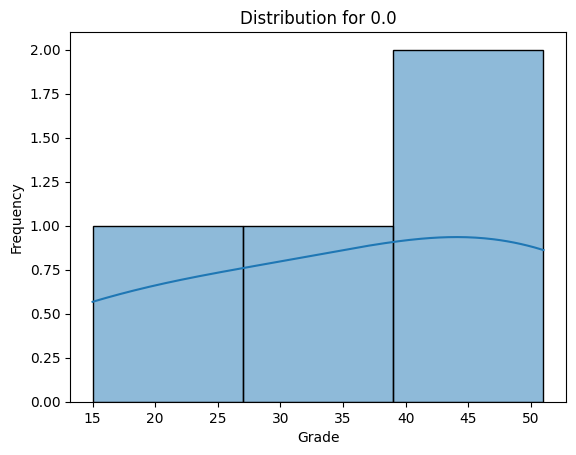

Statistics for 1.0:
count     6.000000
mean     75.833333
std       3.430258
min      71.000000
25%      73.500000
50%      76.500000
75%      78.000000
max      80.000000
Name: grade, dtype: float64


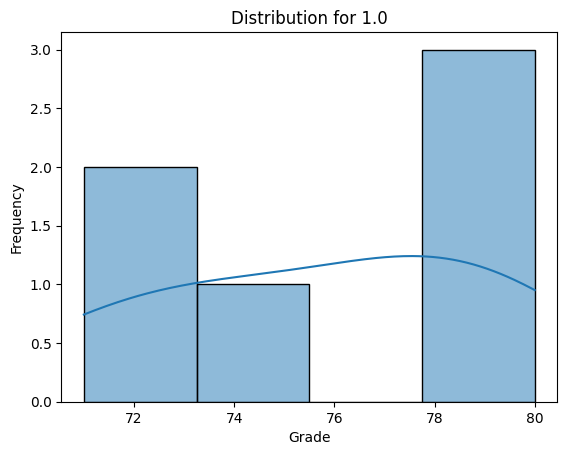

Statistics for 2.0:
count    16.000000
mean     84.812500
std       1.327592
min      82.000000
25%      84.000000
50%      85.000000
75%      86.000000
max      87.000000
Name: grade, dtype: float64


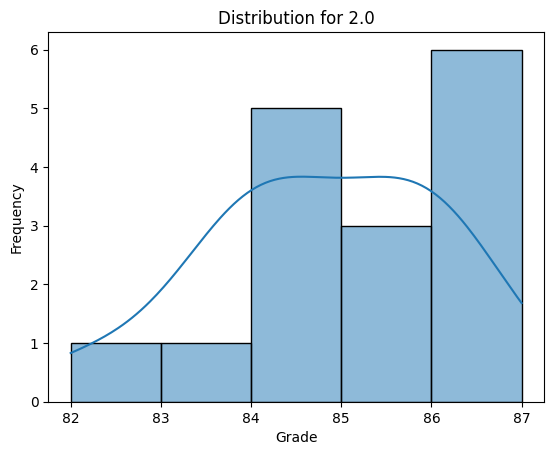

Statistics for 3.0:
count    21.000000
mean     90.666667
std       1.683251
min      88.000000
25%      90.000000
50%      90.000000
75%      92.000000
max      93.000000
Name: grade, dtype: float64


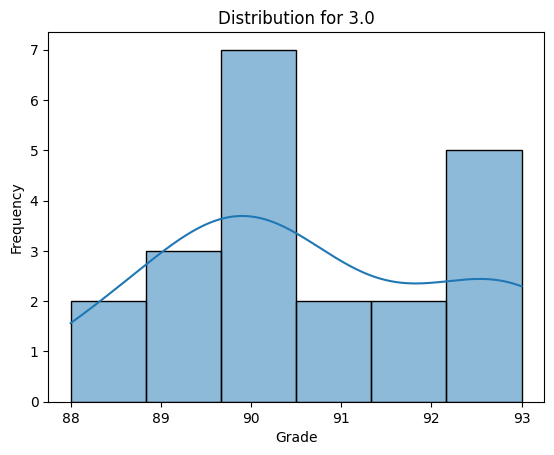

Statistics for 4.0:
count    29.000000
mean     95.413793
std       1.150070
min      94.000000
25%      94.000000
50%      95.000000
75%      96.000000
max      97.000000
Name: grade, dtype: float64


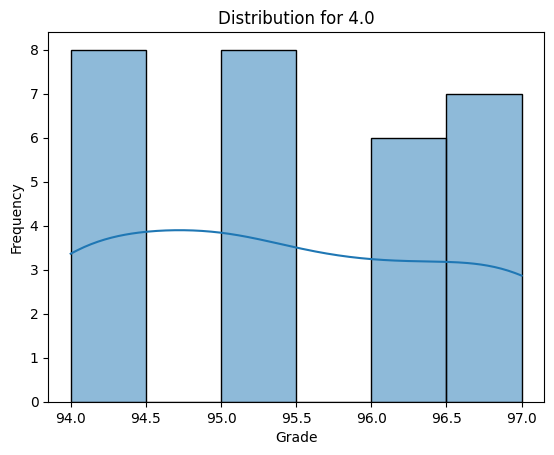

Statistics for 5.0:
count     46.000000
mean      99.260870
std        0.800966
min       98.000000
25%       99.000000
50%       99.000000
75%      100.000000
max      100.000000
Name: grade, dtype: float64


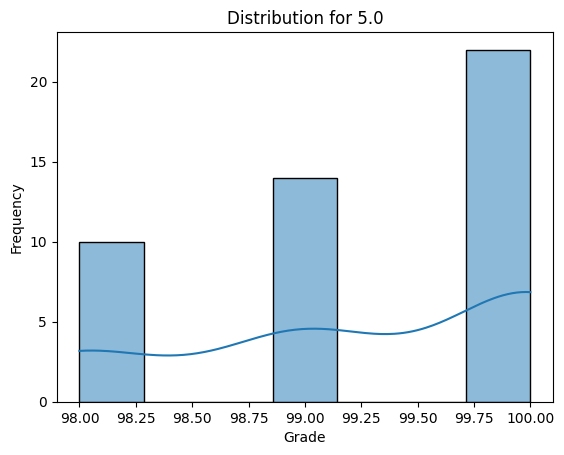

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame creation (replace with your actual data)
# df_prompts = pd.DataFrame({
#     'grade': [...],  # Grades
#     'grade_bins': [...]  # Corresponding bins
# })

# Group the DataFrame by 'grade_bins'
first3Q = df_prompt.iloc[:int(len(df_prompt)*0.75)]

grouped = df_prompt[['grade', 'grade_bin']]
grouped = grouped.groupby('grade_bin')


distributions_df = pd.DataFrame()
# Calculate and print basic statistics for each bin
for bin_name, group in grouped:
    print(f"Statistics for {bin_name}:")
    print(group['grade'].describe())

    # Plotting the distribution within each bin
    plt.figure()
    sns.histplot(group['grade'], kde=True)
    plt.title(f"Distribution for {bin_name}")
    plt.xlabel('Grade')
    plt.ylabel('Frequency')
    plt.show()


In [217]:
import pandas as pd

# Assuming 'grouped' is as previously defined

# Initialize an empty DataFrame for storing statistics
stats_df = pd.DataFrame()

# Iterate over each group and store statistics
for bin_name, group in grouped:
    # Get the descriptive statistics for the 'grade' column
    stats = group['grade'].describe()

    # Create a DataFrame from the statistics and set the index to the bin name
    bin_stats_df = pd.DataFrame(stats).transpose()
    bin_stats_df.index = [bin_name]  # Set the index to the bin name

    # Append the statistics DataFrame of this bin to the overall stats DataFrame
    stats_df = stats_df.append(bin_stats_df)

# Reset the index of stats_df and rename the index column to 'grades_bin'
stats_df.reset_index(inplace=True)
stats_df.rename(columns={'index': 'grades_bin'}, inplace=True)

# Print the resulting DataFrame
print(stats_df)


   grades_bin  count       mean        std   min   25%   50%     75%    max
0         0.0    4.0  36.250000  16.680827  15.0  27.0  39.5   48.75   51.0
1         1.0    6.0  75.833333   3.430258  71.0  73.5  76.5   78.00   80.0
2         2.0   16.0  84.812500   1.327592  82.0  84.0  85.0   86.00   87.0
3         3.0   21.0  90.666667   1.683251  88.0  90.0  90.0   92.00   93.0
4         4.0   29.0  95.413793   1.150070  94.0  94.0  95.0   96.00   97.0
5         5.0   46.0  99.260870   0.800966  98.0  99.0  99.0  100.00  100.0


<ipython-input-217-270a8e6785cd>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(bin_stats_df)
<ipython-input-217-270a8e6785cd>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(bin_stats_df)
<ipython-input-217-270a8e6785cd>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(bin_stats_df)
<ipython-input-217-270a8e6785cd>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(bin_stats_df)
<ipython-input-217-270a8e6785cd>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

In [249]:
import numpy as np
import pandas as pd

# Sample data (replace with your actual DataFrame and statistics DataFrame)
# y_resampled = pd.Series([...])  # This should be your y_resampled data
# stats_df = pd.DataFrame({
#     'grades_bin': [...],
#     'mean': [...],
#     'std': [...]
# })

# Function to generate a random grade based on the grade bin
def generate_random_grade(grade_bin):
    if grade_bin in stats_df['grades_bin'].values:
        mean = stats_df[stats_df['grades_bin'] == grade_bin]['mean'].iloc[0]
        std = stats_df[stats_df['grades_bin'] == grade_bin]['std'].iloc[0]
        return np.random.uniform(mean, std)
    else:
        return np.nan  # Return NaN if the bin is not found

# Apply the function to each element in y_resampled
y_resampled_random_grades = y_resampled.apply(generate_random_grade)

# Display the result
print(y_resampled_random_grades)


0      75.798857
1      29.476173
2      23.170140
3      35.064347
4      29.398794
         ...    
223     8.010694
224    91.381779
225    60.258057
226    66.561337
227    65.339150
Name: grade_bin, Length: 228, dtype: float64


In [250]:
y_resampled_random_grades = np.minimum(y_resampled_random_grades,100)

In [251]:
X_resampled['grade'] = y_resampled_random_grades

# Regress from oversample

In [255]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_resampled.drop(['grade', 'grade_bin'], axis=1), X_resampled['grade'])

preds = regr.predict(df_test.drop(['grade', 'grade_bin'], axis=1))
r2_score(df_test['grade'], preds)

-19.018829309293544

In [256]:
mean_squared_error(df_test['grade'], preds)

2247.4258837054253

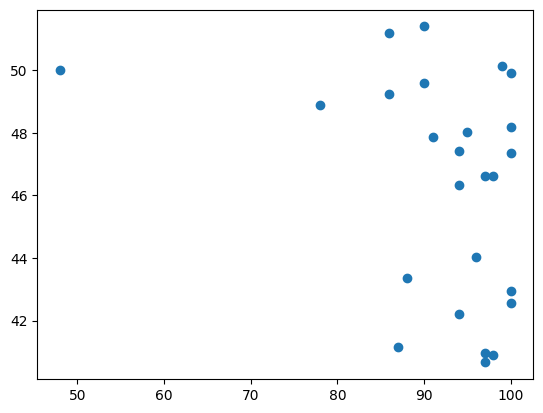

In [257]:
plt.scatter(df_test['grade'], preds)

In [275]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

NN_model = Sequential()
NN_model.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1, activation='relu'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
NN_model.fit(X_resampled.drop(['grade', 'grade_bin'], axis=1).values,  X_resampled['grade'], epochs=50, batch_size=16)

Epoch 1/50
15/15 [==============================] - 3s 20ms/step - loss: 2470.0771 - mse: 2470.0771
Epoch 2/50
15/15 [==============================] - 0s 20ms/step - loss: 2358.1382 - mse: 2358.1382
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 1844.8341 - mse: 1844.8341
Epoch 4/50
15/15 [==============================] - 0s 19ms/step - loss: 871.9344 - mse: 871.9344
Epoch 5/50
15/15 [==============================] - 0s 16ms/step - loss: 646.5372 - mse: 646.5372
Epoch 6/50
15/15 [==============================] - 0s 15ms/step - loss: 622.2244 - mse: 622.2244
Epoch 7/50
15/15 [==============================] - 0s 14ms/step - loss: 604.6315 - mse: 604.6315
Epoch 8/50
15/15 [==============================] - 0s 13ms/step - loss: 568.7218 - mse: 568.7218
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 561.4221 - mse: 561.4221
Epoch 10/50
15/15 [==============================] - 0s 14ms/step - loss: 515.6616 - mse: 515.6616
Epoch 11/50
1

In [276]:
preds = NN_model.predict(df_test.drop(['grade', 'grade_bin'], axis=1).values)
r2_score(df_test['grade'], preds)

1/1 [==============================] - 0s 68ms/step


-21.316648173008712

In [277]:
mean_squared_error(df_test['grade'], preds)

2505.3918971317266

# Predict Grade Bin From Oversample and Regress

In [227]:
X_resampled['grade_bin'] = pd.cut(X_resampled['grade'], bins=bins, labels=False)

<ipython-input-227-70dc9b54fb2d>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_resampled['grade_bin'] = pd.cut(X_resampled['grade'], bins=bins, labels=False)


In [228]:
X_resampled

,00,000,000000,000284among,00075,000750,000750â,001,01,010484island,...,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼,grade,grade_bin
0,0.0,0.0,0.0,0.0,0.014333,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,98.819317,5
1,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,36.819316,0
2,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,95.701334,4
3,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,94.096173,4
4,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,99.128233,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,96.735508,4
224,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,96.181662,4
225,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,96.822418,4
226,0.0,0.0,0.0,0.0,0.000000,0.00052,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000633,95.930101,4


In [241]:
## FOR BIN CLASSIFICATION WITH ANSWERS
one_hot = pd.get_dummies(X_resampled['grade_bin'])

In [231]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

NN_model = Sequential()
NN_model.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(6, activation='softmax'))

# Compile the network :
NN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model.fit(X_resampled.drop(['grade', 'grade_bin'], axis=1).values, one_hot.values, epochs=13, batch_size=4)

Epoch 1/13
57/57 [==============================] - 3s 19ms/step - loss: 1.7909 - accuracy: 0.1535
Epoch 2/13
57/57 [==============================] - 1s 19ms/step - loss: 1.7801 - accuracy: 0.2281
Epoch 3/13
57/57 [==============================] - 1s 12ms/step - loss: 1.7377 - accuracy: 0.2632
Epoch 4/13
57/57 [==============================] - 1s 12ms/step - loss: 1.5426 - accuracy: 0.4430
Epoch 5/13
57/57 [==============================] - 1s 12ms/step - loss: 1.2764 - accuracy: 0.4912
Epoch 6/13
57/57 [==============================] - 1s 12ms/step - loss: 1.0699 - accuracy: 0.5658
Epoch 7/13
57/57 [==============================] - 1s 12ms/step - loss: 0.8790 - accuracy: 0.6228
Epoch 8/13
57/57 [==============================] - 1s 13ms/step - loss: 0.7485 - accuracy: 0.6886
Epoch 9/13
57/57 [==============================] - 1s 15ms/step - loss: 0.7137 - accuracy: 0.7105
Epoch 10/13
57/57 [==============================] - 1s 15ms/step - loss: 0.6143 - accuracy: 0.7412
Epoch 11/

In [233]:
pred = NN_model.predict(df_test.drop(['grade', 'grade_bin'], axis=1).values)
loss, accuracy = NN_model.evaluate(df_test.drop(['grade', 'grade_bin'], axis =1).values, pd.get_dummies(df_test['grade_bin']))

1/1 [==============================] - 0s 29ms/step - loss: 2.1965 - accuracy: 0.2400


In [234]:
pred = np.argmax(pred, axis =1)

In [235]:
pred

array([5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 5, 5, 2, 4, 5, 2, 5, 5, 4, 5,
       5, 5, 5])

In [236]:
one_hot = pd.get_dummies(pred)

In [237]:
y_train = X_resampled['grade']
X_train = X_resampled.drop(['grade'], axis = 1)

y_test = df_test['grade']
X_test = df_test.drop(['grade'], axis = 1)
X_test['B_0'] = 0
X_test['B_1'] = 0
X_test['B_2'] = one_hot[2].to_numpy()
X_test['B_3'] = one_hot[3].to_numpy()

In [238]:
X_test.drop('grade_bin', axis=1, inplace=True)

In [239]:
X_test

,00,000,000000,000284among,00075,000750,000750â,001,01,010484island,...,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼,B_0,B_1,B_2,B_3
18,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
45,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
47,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
89,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
40,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
62,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
107,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.014082,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
31,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
55,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [243]:
from sklearn.ensemble import RandomForestRegressor
## FOR BIN CLASSIFICATION WITH ANSWERS
one_hot = pd.get_dummies(X_resampled['grade_bin'])
regr = RandomForestRegressor(n_estimators=20)
regr.fit(one_hot, X_resampled['grade'])

preds = regr.predict(X_test.iloc[:, -6:])
r2_score(y_test, preds)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


-0.21958969168572606

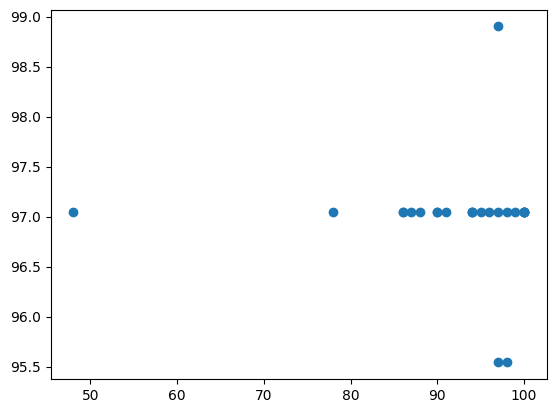

In [244]:
plt.scatter(y_test, preds)